In [1]:
# import for rosbag
%matplotlib inline
import os
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot

In [2]:
# function to get pose from bag file
def get_pose(data_dir, bag_file, topic):

    """
    Args:
        data_dir (str): directory where bag file is stored
        bag_file (str): name of bag file
        topic (str): topic name to extract pose data from

    Returns:
        poses (np.array): array of poses
        timestamps (np.array): array of timestamps
    """
    
    # lists to store data
    poses = []
    timestamps = []
    
    # create reader instance and open for reading
    with Reader(os.path.join(data_dir, bag_file)) as reader:

        # topic and msgtype information is available on .connections list
        # for connection in reader.connections:
        #     print(connection.topic, connection.msgtype)

        # iterate over messages
        for connection, timestamp, rawdata in reader.messages():
            
            if connection.topic == topic:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                poses.append([msg.pose.position.x, msg.pose.position.y, msg.pose.position.z, msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z, msg.pose.orientation.w])
                timestamps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)
        
    # convert to numpy array
    poses = np.array(poses)
    timestamps = np.array(timestamps)

    return poses, timestamps

In [3]:
# function to get twist from bag file
def get_twist(data_dir, bag_file, topic):

    """
    Args:
        data_dir (str): directory where bag file is stored
        bag_file (str): name of bag file
        topic (str): topic name to extract twist data from

    Returns:
        twists (np.array): array of twists
        timestamps (np.array): array of timestamps
    """
    
    # lists to store data
    twists = []
    timestamps = []
    
    # create reader instance and open for reading
    with Reader(os.path.join(data_dir, bag_file)) as reader:

        # topic and msgtype information is available on .connections list
        # for connection in reader.connections:
        #     print(connection.topic, connection.msgtype)

        # iterate over messages
        for connection, timestamp, rawdata in reader.messages():
            
            if connection.topic == topic:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                twists.append([msg.twist.linear.x, msg.twist.linear.y, msg.twist.linear.z, msg.twist.angular.x, msg.twist.angular.y, msg.twist.angular.z])
                timestamps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)
        
    # convert to numpy array
    twists = np.array(twists)
    timestamps = np.array(timestamps)

    return twists, timestamps

In [4]:
# function to get accel from bag file
def get_accel(data_dir, bag_file, topic):

    """
    Args:
        data_dir (str): directory where bag file is stored
        bag_file (str): name of bag file
        topic (str): topic name to extract accel data from

    Returns:
        accels (np.array): array of accels
        timestamps (np.array): array of timestamps
    """
    
    # lists to store data
    accels = []
    timestamps = []
    
    # create reader instance and open for reading
    with Reader(os.path.join(data_dir, bag_file)) as reader:

        # topic and msgtype information is available on .connections list
        # for connection in reader.connections:
        #     print(connection.topic, connection.msgtype)

        # iterate over messages
        for connection, timestamp, rawdata in reader.messages():
            
            if connection.topic == topic:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                accels.append([msg.accel.linear.x, msg.accel.linear.y, msg.accel.linear.z, msg.accel.angular.x, msg.accel.angular.y, msg.accel.angular.z])
                timestamps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)
        
    # convert to numpy array
    accels = np.array(accels)
    timestamps = np.array(timestamps)

    return accels, timestamps

In [5]:
# function for time synchronization and pose transformation
def sync_and_transform(ground_truth_poses, ground_truth_timestamps, estimate_poses, estimate_timestamps, ground_truth_twist, ground_truth_twist_timestamps, ground_truth_accel, ground_truth_accel_timestamps, freq=0.5):

    # find the common timestamps
    start_time = estimate_timestamps[0] if estimate_timestamps[0] > ground_truth_timestamps[0] else ground_truth_timestamps[0]

    # find the end time
    end_time = estimate_timestamps[-1] if estimate_timestamps[-1] < ground_truth_timestamps[-1] else ground_truth_timestamps[-1]

    # find the base timsstamps
    timestamps_sync = np.arange(start_time, end_time, 1.0/freq)

    # synchronize poses with timestamps
    ground_truth_poses_sync = []
    estimate_poses_sync = []
    ground_truth_twist_sync = []
    ground_truth_twist_accel_sync = []
    
    for timestamp in timestamps_sync:

        # find the index that is closest to the timestamp
        ground_truth_idx = np.argmin(np.abs(ground_truth_timestamps - timestamp))
        estimate_idx = np.argmin(np.abs(estimate_timestamps - timestamp))
        ground_truth_twist_idx = np.argmin(np.abs(ground_truth_twist_timestamps - timestamp))
        ground_truth_accel_idx = np.argmin(np.abs(ground_truth_accel_timestamps - timestamp))

        ground_truth_poses_sync.append(ground_truth_poses[ground_truth_idx])
        estimate_poses_sync.append(estimate_poses[estimate_idx])
        ground_truth_twist_sync.append(ground_truth_twist[ground_truth_twist_idx])
        ground_truth_twist_accel_sync.append(ground_truth_accel[ground_truth_accel_idx])

    # convert to numpy array
    ground_truth_poses_sync = np.array(ground_truth_poses_sync)
    estimate_poses_sync = np.array(estimate_poses_sync)
    ground_truth_twist_sync = np.array(ground_truth_twist_sync)
    ground_truth_twist_accel_sync = np.array(ground_truth_twist_accel_sync)

    return ground_truth_poses_sync, estimate_poses_sync, ground_truth_twist_sync, ground_truth_twist_accel_sync, timestamps_sync

In [6]:
# function for plot
def plot_poses(ground_truth_poses, estimate_poses, raw_estimate_poses=None):
    
    # create figure
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # compute rotation matrix from quaternion
    ground_truth_rotations = Rot.from_quat(ground_truth_poses[:, 3:]).as_matrix()
    estimate_rotations = Rot.from_quat(estimate_poses[:, 3:]).as_matrix()

    # plot
    for i in range(len(ground_truth_poses)):
        
        # plot points
        ax.scatter(ground_truth_poses[i, 0], ground_truth_poses[i, 1], ground_truth_poses[i, 2], color="blue", label="ground truth" if i == 0 else "")
        ax.scatter(estimate_poses[i, 0], estimate_poses[i, 1], estimate_poses[i, 2], color="red", label="estimate" if i == 0 else "")
        if raw_estimate_poses is not None:
            ax.scatter(raw_estimate_poses[i, 0], raw_estimate_poses[i, 1], raw_estimate_poses[i, 2], color="green")

        # plot ground truth
        ax.quiver(ground_truth_poses[i, 0], ground_truth_poses[i, 1], ground_truth_poses[i, 2], ground_truth_rotations[i, 0, :], ground_truth_rotations[i, 1, :], ground_truth_rotations[i, 2, :], color="blue")

        # plot estimate
        ax.quiver(estimate_poses[i, 0], estimate_poses[i, 1], estimate_poses[i, 2], estimate_rotations[i, 0, :], estimate_rotations[i, 1, :], estimate_rotations[i, 2, :], color="red")

        # plot raw estimate
        if raw_estimate_poses is not None:
            ax.quiver(raw_estimate_poses[i, 0], raw_estimate_poses[i, 1], raw_estimate_poses[i, 2], estimate_rotations[i, 0, :], estimate_rotations[i, 1, :], estimate_rotations[i, 2, :], color="green")

        # plot lines connecting the points from the previous to the current
        if i > 0:
            ax.plot([ground_truth_poses[i-1, 0], ground_truth_poses[i, 0]], [ground_truth_poses[i-1, 1], ground_truth_poses[i, 1]], [ground_truth_poses[i-1, 2], ground_truth_poses[i, 2]], color="blue")
            ax.plot([estimate_poses[i-1, 0], estimate_poses[i, 0]], [estimate_poses[i-1, 1], estimate_poses[i, 1]], [estimate_poses[i-1, 2], estimate_poses[i, 2]], color="red")

    # set labels
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    
    # set legend
    ax.legend()

    # equal axis
    # ax.set_box_aspect([1,1,1])

    # set limits
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(0, 3)

    # set title
    ax.set_title("Pose comparison")
    
    # show plot
    plt.show()

In [7]:
# function to align the poses
def align_poses(ground_truth_poses, estimate_poses):

    # estimate-poses are in their own frame, where the first pose is the origin of the frame
    # ground-truth poses are in the world frame

    # world to livox frame
    R_w2l = Rot.from_quat(ground_truth_poses[0, 3:]).as_matrix()
    t_w2l = ground_truth_poses[0, :3]
    T_w2l = np.eye(4)
    T_w2l[:3, :3] = R_w2l
    T_w2l[:3, 3] = t_w2l

    # transform the estimate poses
    estimate_poses_aligned = np.zeros_like(estimate_poses)
    for i in range(len(estimate_poses)):

        # livox to estimate frame
        R_l2e = Rot.from_quat(estimate_poses[i, 3:]).as_matrix()
        t_l2e = estimate_poses[i, :3]
        T_l2e = np.eye(4)
        T_l2e[:3, :3] = R_l2e
        T_l2e[:3, 3] = t_l2e + [0, 0, 0.22] # Livox has some offset in z direction

        T_w2e = T_l2e @ T_w2l

        estimate_poses_aligned[i, :3] = T_w2e[:3, 3]
        estimate_poses_aligned[i, 3:] = Rot.from_matrix(T_w2e[:3, :3]).as_quat()

    return estimate_poses_aligned

In [11]:
# function to compute the error
def plot_error(ground_truth_poses_sync, estimate_poses_aligned, ground_truth_twist_sync, ground_truth_accel_sync, timestamps_sync, plot_freq=0.2):

    position_error = np.linalg.norm(ground_truth_poses_sync[:, :3] - estimate_poses_aligned[:, :3], axis=1)

    # compute the orientation error (frobenius norm of the rotation_matrix_gt @ rotation_matrix_est.T - I)
    euler_gt = Rot.from_quat(ground_truth_poses_sync[:, 3:]).as_euler("xyz", degrees=True)
    euler_est = Rot.from_quat(estimate_poses_aligned[:, 3:]).as_euler("xyz", degrees=True)
    roll_error = np.abs(euler_gt[:, 0] - euler_est[:, 0])
    pitch_error = np.abs(euler_gt[:, 1] - euler_est[:, 1])
    yaw_error = np.abs(euler_gt[:, 2] - euler_est[:, 2])

    # plot the error
    fig, ax = plt.subplots(4, 1, figsize=(15, 15))
    
    # x axis should start from 0 to the end based on timestamps_sync
    start_time = timestamps_sync[0]
    end_time = timestamps_sync[-1]
    labels = np.arange(0, end_time - start_time, 1.0/plot_freq)
    for i in range(4):
        ax[i].set_xticks(labels)
        ax[i].set_xticklabels(labels)

    # plot
    ax[0].plot(position_error)
    ax[0].set_title("Position error")
    # ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Error [m]")
    ax[1].plot(roll_error, label="Roll")
    ax[1].plot(pitch_error, label="Pitch")
    ax[1].plot(yaw_error, label="Yaw")
    ax[1].set_title("Rotation error")
    # ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Error [deg]")
    ax[2].plot(ground_truth_twist_sync[:, :3])
    ax[2].set_title("Ground truth linear velocity")
    # ax[2].set_xlabel("Time")
    ax[2].set_ylabel("Linear vel [m/s]")
    ax[3].plot(ground_truth_twist_sync[:, 3:])
    ax[3].set_title("Ground truth angular velocity")
    ax[3].set_xlabel("Time")
    ax[3].set_ylabel("Angular vel [rad/s]")
    
    # ax[3].plot(ground_truth_accel_sync)
    # ax[3].set_title("Ground truth acceleration")
    # ax[3].set_xlabel("Time")
    # ax[3].set_ylabel("Acceleration [m/s^2, rad/s^2]")


    plt.show()

In [12]:
# main

def main(data_dir, test_num, freq=0.5, plot_freq=0.2):

    # get poses
    ground_truth_poses, ground_truth_timestamps = get_pose(data_dir, f"test{test_num}", "/livox_drone/world")
    ground_truth_twist, ground_truth_twist_timestamps = get_twist(data_dir, f"test{test_num}", "/livox_drone/mocap/twist")
    ground_truth_accel, ground_truth_accel_timestamps = get_accel(data_dir, f"test{test_num}", "/livox_drone/mocap/accel")
    estimate_poses, estimate_timestamps = get_pose(data_dir, f"test{test_num}_onboard", "/dlio/odom_node/pose")

    # synchronize and transform
    ground_truth_poses_sync, estimate_poses_sync, ground_truth_twist_sync, ground_truth_accel_sync, timestamps_sync = sync_and_transform(ground_truth_poses, ground_truth_timestamps, estimate_poses, estimate_timestamps, ground_truth_twist, ground_truth_twist_timestamps, ground_truth_accel, ground_truth_accel_timestamps, freq=freq)
    assert ground_truth_poses_sync.shape[0] == estimate_poses_sync.shape[0] == ground_truth_twist_sync.shape[0] == ground_truth_accel_sync.shape[0]

    # align frames of reference
    estimate_poses_aligned = align_poses(ground_truth_poses_sync, estimate_poses_sync)

    # plot
    plot_poses(ground_truth_poses_sync, estimate_poses_aligned)

    # compute error
    plot_error(ground_truth_poses_sync, estimate_poses_aligned, ground_truth_twist_sync, ground_truth_accel_sync, timestamps_sync, plot_freq=plot_freq)

/tmp/ipykernel_418759/99341717.py:30: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


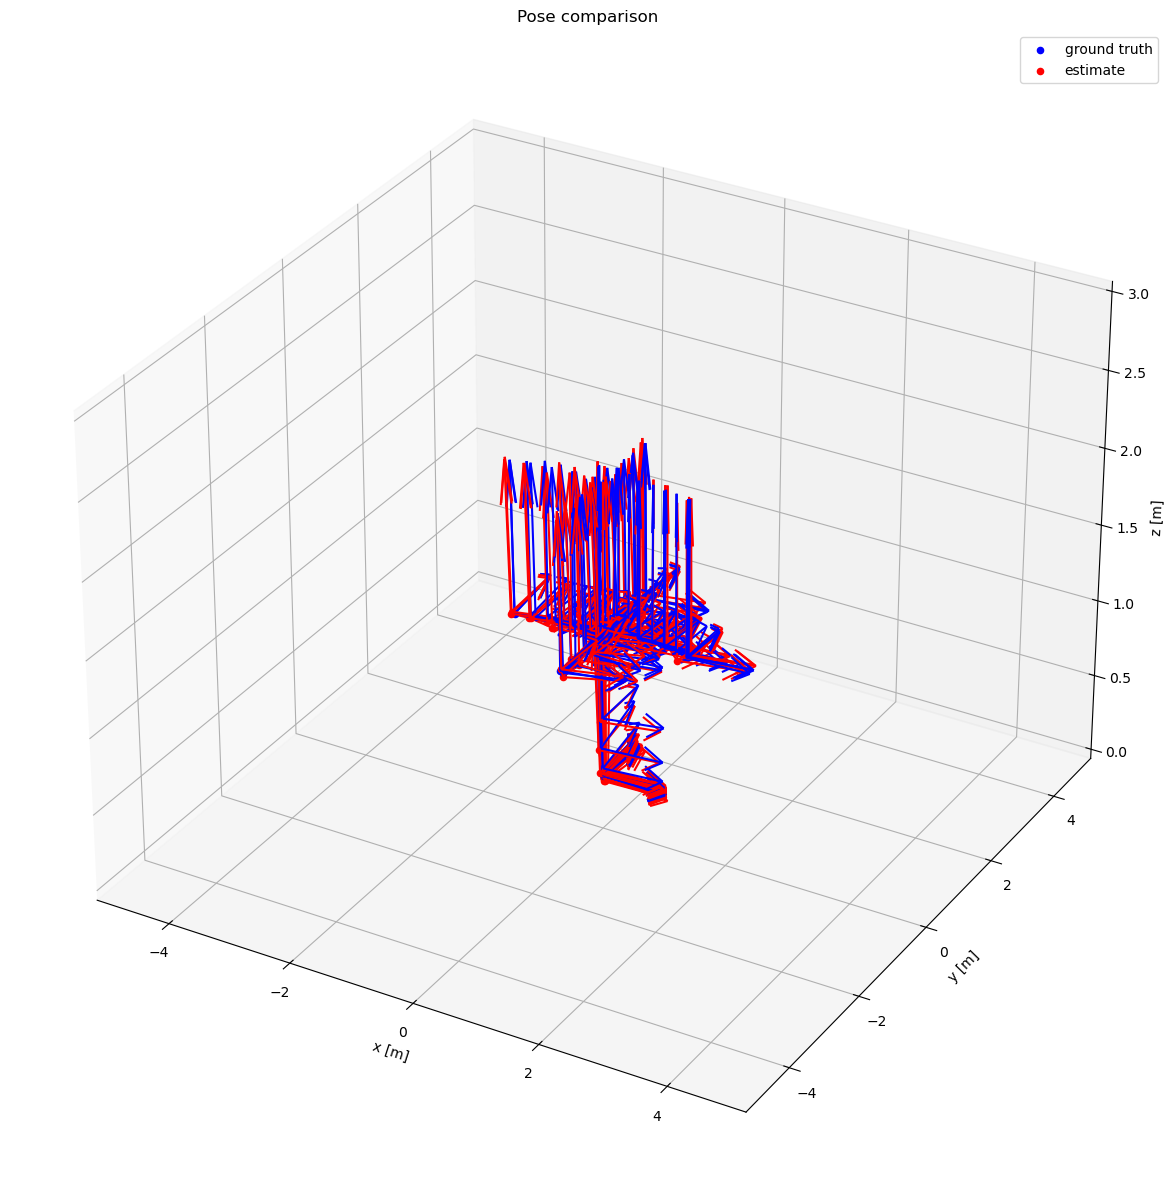

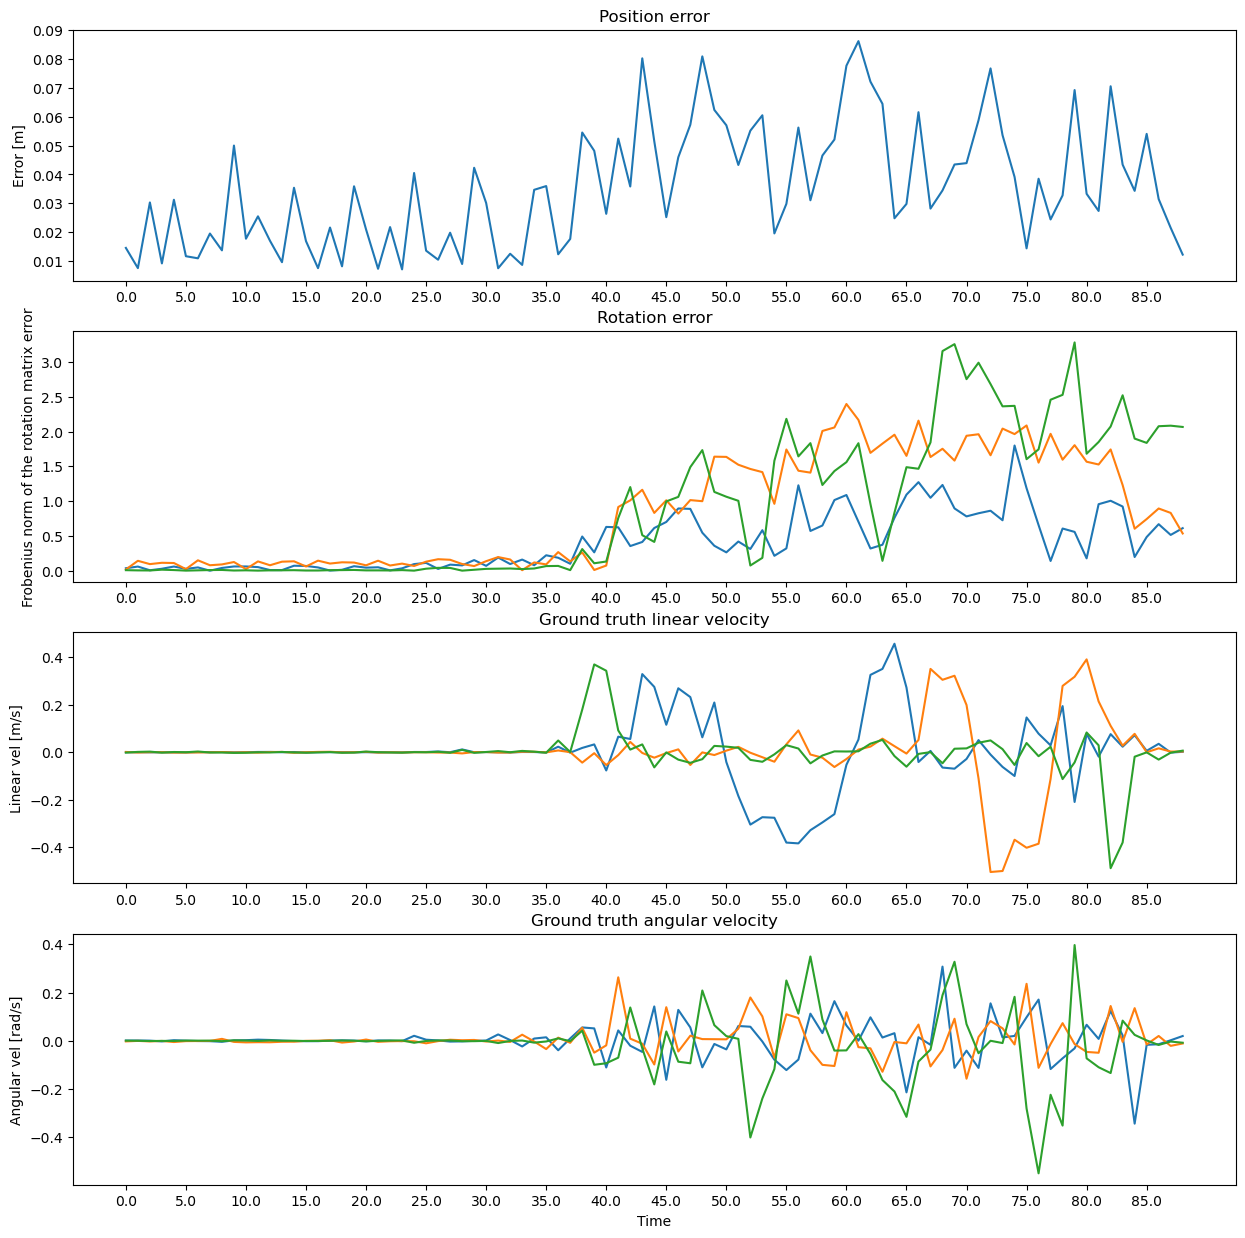

/tmp/ipykernel_418759/99341717.py:30: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


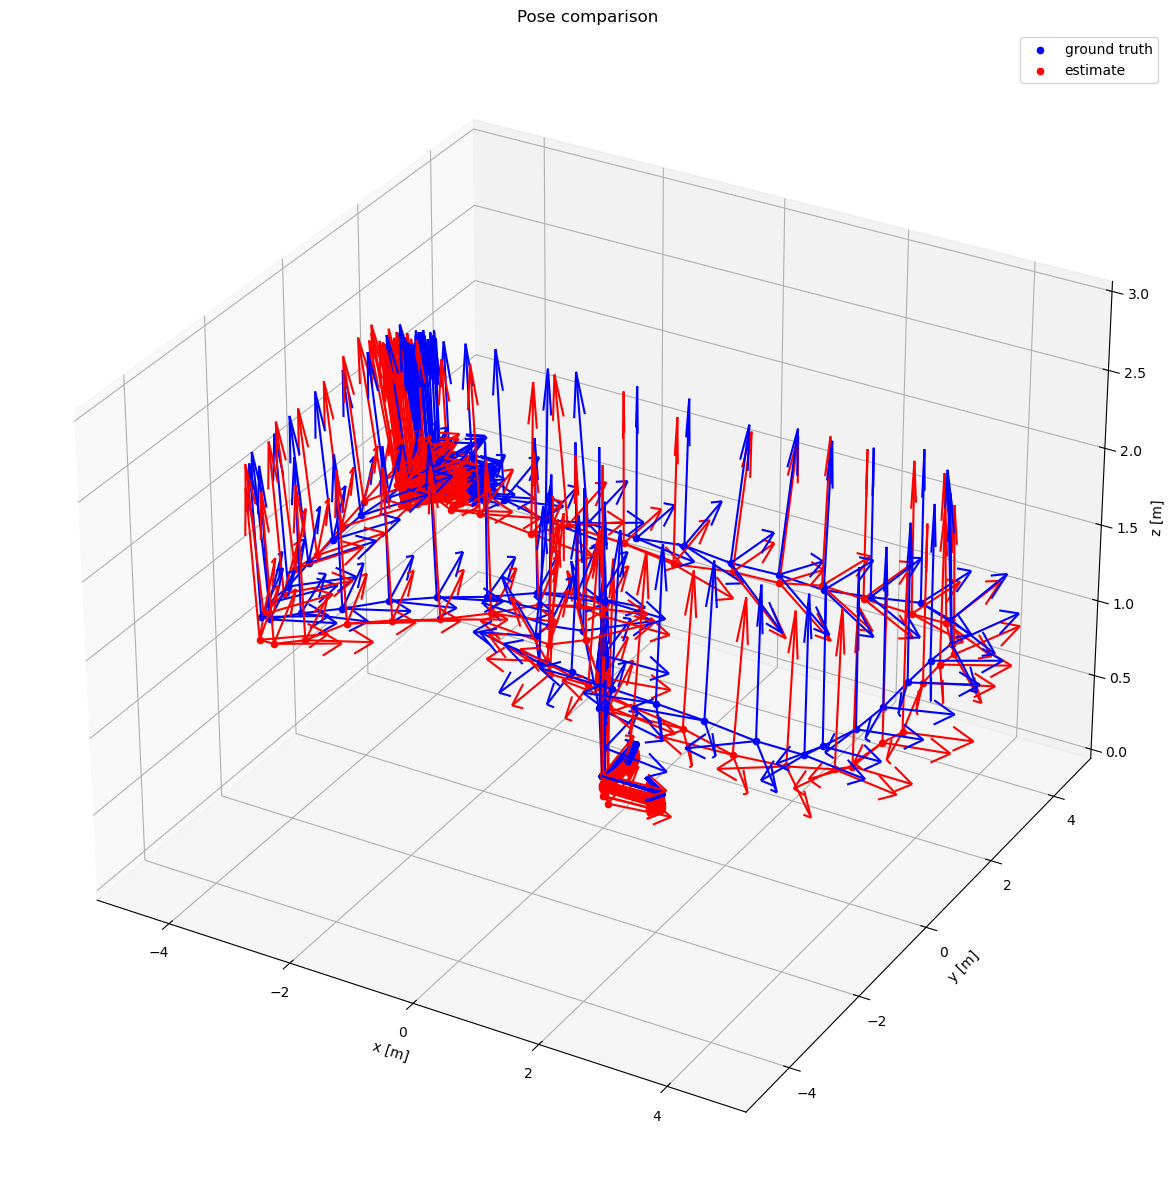

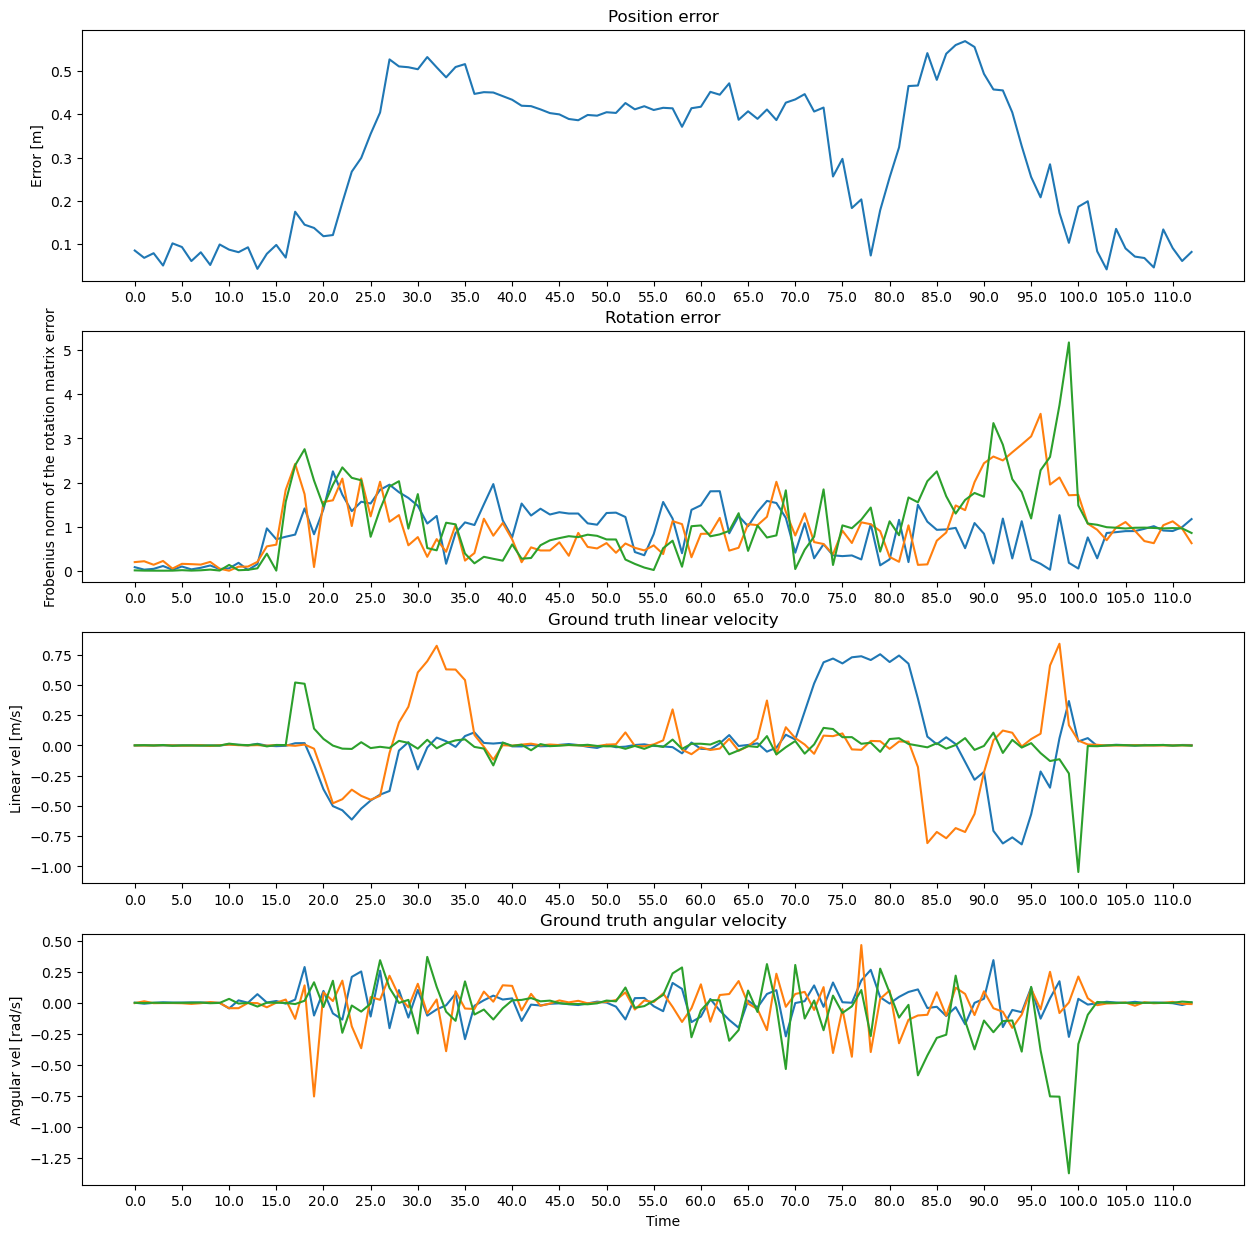

/tmp/ipykernel_418759/99341717.py:30: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


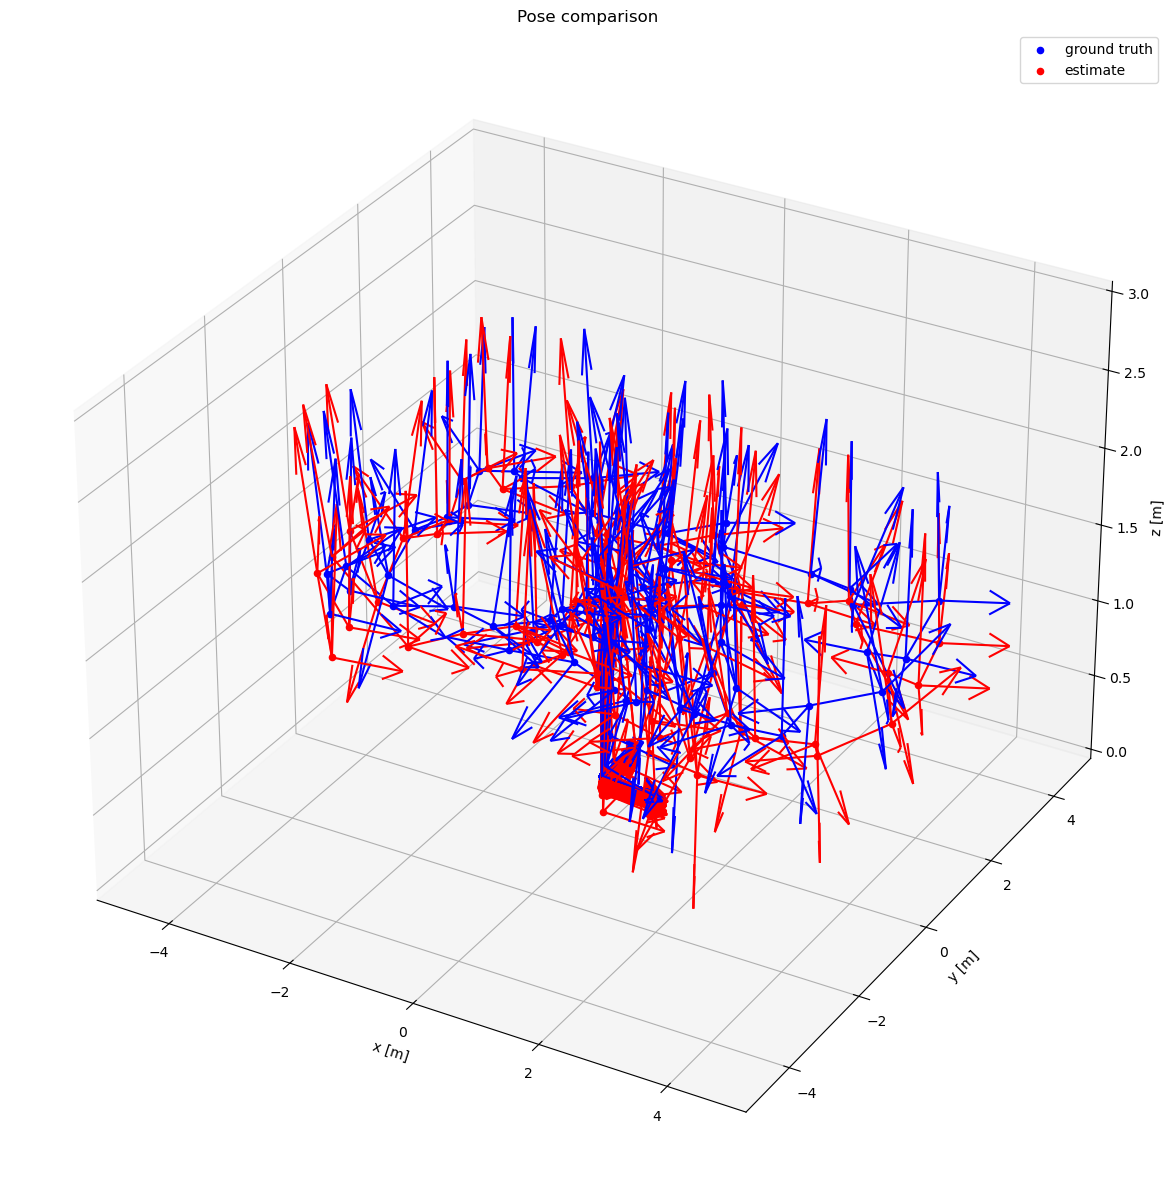

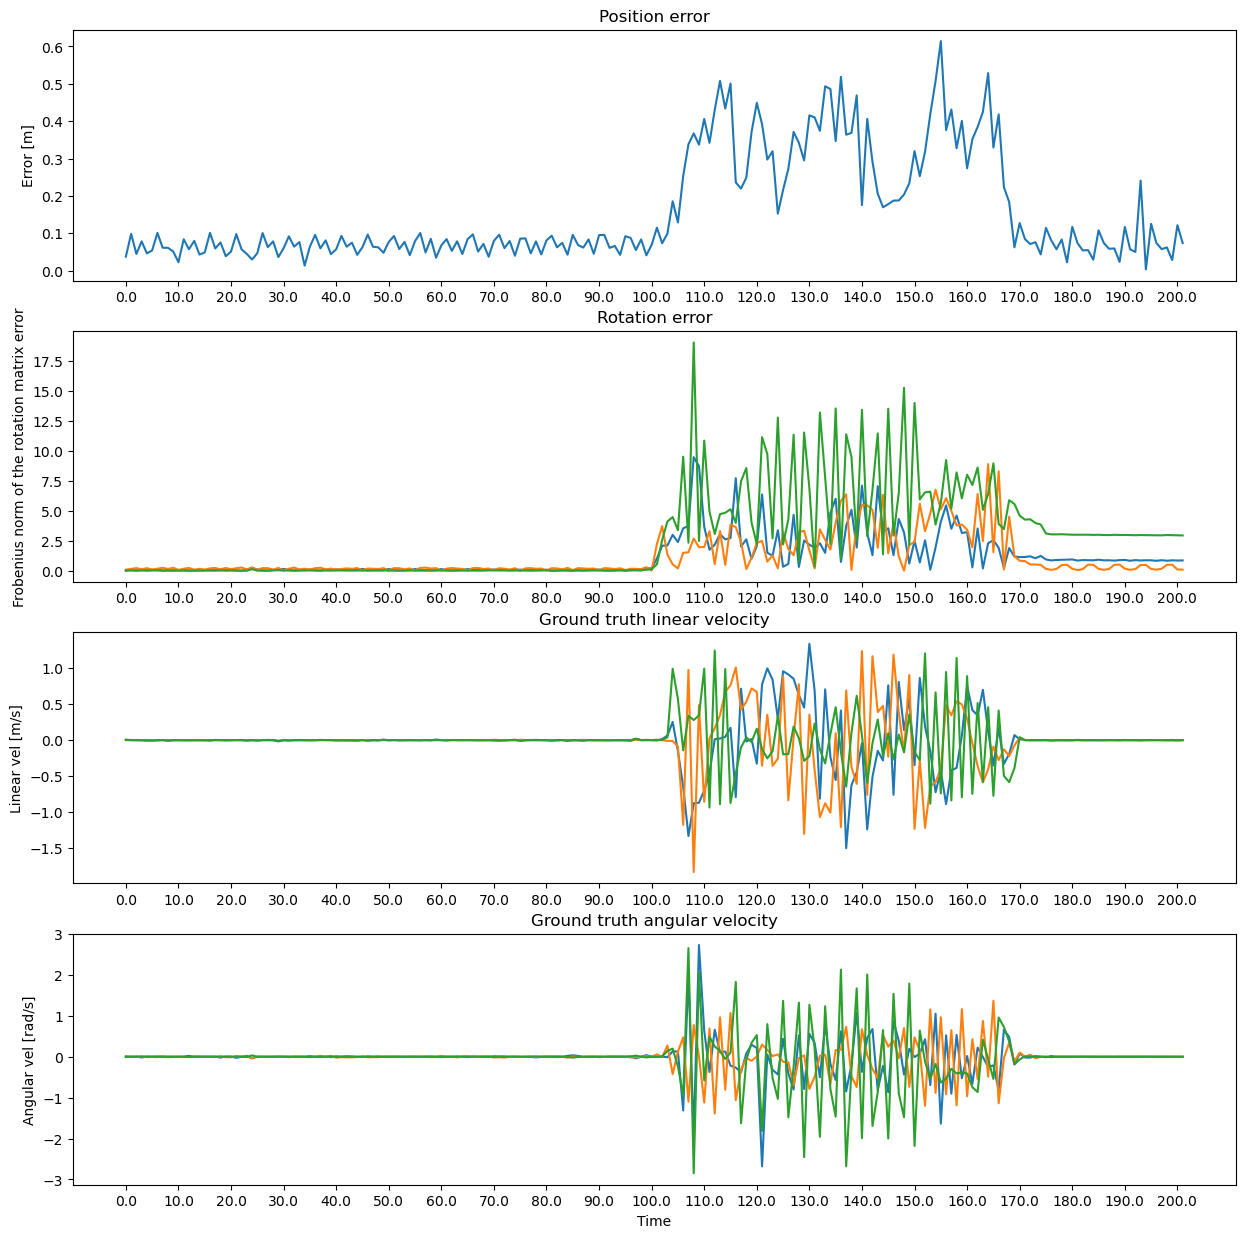

In [13]:
# run main

# constants
data_dir = "/home/kkondo/data/bags/lidar_test"
freq = 1.0 # Hz

# variables
test_nums = ["5", "6", "7"]
for test_num in test_nums:
    main(data_dir, test_num, freq=freq, plot_freq=0.1 if test_num == "7" else 0.2)

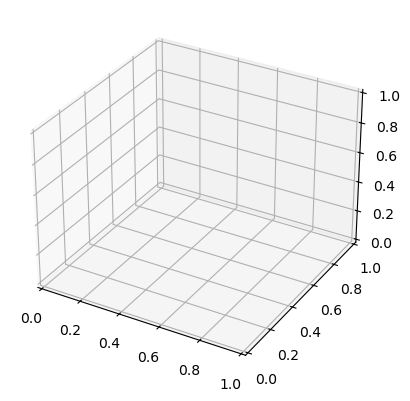

In [174]:
# animate data
from matplotlib.animation import FuncAnimation

fix, ax = plt.subplots(subplot_kw=dict(projection='3d'))



